In [82]:
import h5py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pymatgen.core import Composition
from matplotlib.patches import Patch
from decifer_refactored.utility import (
    extract_formula_nonreduced,
    space_group_symbol_to_number,
    element_to_atomic_number,
    replace_symmetry_loop_with_P1,
    generate_continuous_xrd_from_cif,
)

# Function to classify dataset
def classify_dataset(cif_name):
    if cif_name.startswith('NOMAD'):
        return 'NOMAD'
    elif cif_name.startswith('OQMD'):
        return 'OQMD'
    elif cif_name.startswith('MP'):
        return 'MP'
    else:
        return 'CHILI-100K'

# Function to process a single index
def process_single_index(args):
    i, file_path = args
    with h5py.File(file_path, 'r') as f:
        cif_name = f['cif_name'][i].decode("utf-8")
        cif_string = f['cif_string'][i].decode("utf-8")
        comp = Composition(extract_formula_nonreduced(cif_string)).reduced_composition.as_dict()
        spacegroup_num = space_group_symbol_to_number(f['spacegroup'][i].decode("utf-8"))
        atomic_numbers = [element_to_atomic_number(e) * n for e, n in comp.items()]
        species = list(comp.keys())
        try:
            cif_tokens_len = len(f['cif_tokens'][i])
        except:
            cif_tokens_len = len(f['cif_tokenized'][i])
        return {
            'cif_name': cif_name,
            'cif_string': cif_string,
            'spacegroup_num': spacegroup_num,
            'species': species,
            'atomic_numbers': atomic_numbers,
            'num_elements': len(species),
            'dataset': classify_dataset(cif_name),
            'cif_token_len': cif_tokens_len,
        }

# Extract data using multiprocessing
def extract_data_from_file(file_path, debug_max=None):
    with h5py.File(file_path, 'r') as f:
        num_files = min(debug_max, len(f['cif_name'])) if debug_max else len(f['cif_name'])

    args = [(i, file_path) for i in range(num_files)]
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_single_index, args), total=num_files, desc=f'Processing {file_path}'))
    return results

# Process all files using multiprocessing
def process_all_files(data_paths, debug_max=None):
    all_data = []
    for path in data_paths:
        all_data.extend(extract_data_from_file(path, debug_max))
    return pd.DataFrame(all_data)


# Visualization
def visualize_data(
    data_df,
    exploded_df,
    species_order,
    species_order_labels,
    output_file,
    figsize=(12,5),
    bbox_to_anchor=(0.5, 1.10),
    log_scale=False,
    legend_labels=['NOMAD', 'OQMD', 'MP', 'CHILI-100K'],
    legend_skip_colors=0,
    cif_token_len_bins=100,
    special_element_fontsize = 9,
    text_height = 1000,
):
    COLORS = sns.color_palette()[legend_skip_colors:]
    palette = {label:COLORS[i] for i, label in enumerate(legend_labels)}
    fig, axes = plt.subplots(4, 1, figsize=figsize, dpi=300)

    # Plot 1: Spacegroup Number
    sns.histplot(
        data=data_df, x="spacegroup_num", hue="dataset", ax=axes[0],
        multiple='stack', bins=230, edgecolor='k', legend=False, discrete=True, palette=palette
    )
    if log_scale:
        axes[0].set_yscale('log')
    axes[0].set_xticks(np.arange(1, 230, 20))
    axes[0].set_xlabel('Spacegroup Number')
    axes[0].set_ylabel('CIF Count')

    # Plot 2: Number of Elements
    sns.histplot(
        data=data_df, x="num_elements", hue="dataset", ax=axes[1],
        multiple='dodge', bins=94, edgecolor='k', legend=False, discrete=True, shrink=0.75, palette=palette
    )
    if log_scale:
        axes[1].set_yscale('log')
    axes[1].set_xlabel('Number of Elements in Unit Cells')
    axes[1].set_ylabel('CIF Count')

    # Plot 3: Elemental Species
    sns.histplot(
        data=exploded_df, x="species", hue="dataset", ax=axes[2],
        multiple='stack', edgecolor='k', legend=False, discrete=True, palette=palette
    )
    if log_scale:
        axes[2].set_yscale('log')
    axes[2].set_xlabel('Element')
    axes[2].set_ylabel('Occurrences')
    axes[2].set_xticks(range(len(species_order_labels)))
    axes[2].set_xticklabels(species_order_labels, rotation=90, fontsize=special_element_fontsize)

    # Plot 4: CIF token length
    sns.histplot(
        data=exploded_df, x='cif_token_len', hue='dataset', ax=axes[3],
        multiple='stack',  bins=cif_token_len_bins, edgecolor='k', legend=False, palette=palette,
    )
    if log_scale:
        axes[3].set_yscale('log')
    axes[3].set_xlabel('CIF token length')
    axes[3].set_ylabel('Occurences')

    # Add arrow with text "hello" on axes[3]
    axes[3].annotate(
        f'{len(data_df[(data_df["cif_token_len"] > 3072) == True]) / len(data_df) * 100:1.3f}%', 
        xy=(data_df["cif_token_len"].max(), text_height),  # Arrow tip
        xytext=(3072, text_height),  # Text location
        arrowprops=dict(facecolor='black', arrowstyle='|-|'),
        fontsize=14,
        va='center'
    )

    # Add legend
    fig.tight_layout(rect=[0, 0, 1, 0.9])
    handles = [Patch(color=COLORS[i], label=label) for i, label in enumerate(legend_labels)]
    axes[0].legend(handles=handles, title='Dataset', loc='upper center', frameon=False, ncol=4, bbox_to_anchor=bbox_to_anchor)

    fig.savefig(output_file + '.pdf', transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(output_file + '.png', transparent=True, bbox_inches='tight', dpi=300)
    plt.show()


In [47]:
# Configuration
DATA_PATHS = [
    '../data/crystallm/full/serialized/train.h5',
    '../data/crystallm/full/serialized/val.h5',
    '../data/crystallm/full/serialized/test.h5',
]
DEBUG_MAX = None

data_df = process_all_files(DATA_PATHS, DEBUG_MAX)

# Explode atomic data
exploded_df = data_df.explode(['species', 'atomic_numbers'], ignore_index=True)
exploded_df['atomic_numbers'] = exploded_df['atomic_numbers'].astype(int)
exploded_df['species'] = exploded_df['species'].astype(str)
# Order species
species_order = (
    exploded_df[['species', 'atomic_numbers']]
    .drop_duplicates()
    .sort_values('atomic_numbers')['species']
    .unique()  # Ensure unique values
)
# Convert species to a categorical type with the desired order
exploded_df['species'] = pd.Categorical(exploded_df['species'], categories=species_order, ordered=True)
# Define labels (use your predefined arrays if necessary)
species_order_labels = [f"{species} ({atomic_number})" for species, atomic_number in zip(species_order, sorted(exploded_df['atomic_numbers'].unique()))]

Processing ../data/crystallm/full/serialized/train.h5:   0%|          | 0/2169177 [00:00<?, ?it/s]

Processing ../data/crystallm/full/serialized/val.h5:   0%|          | 0/57084 [00:00<?, ?it/s]

Processing ../data/crystallm/full/serialized/test.h5:   0%|          | 0/57085 [00:00<?, ?it/s]

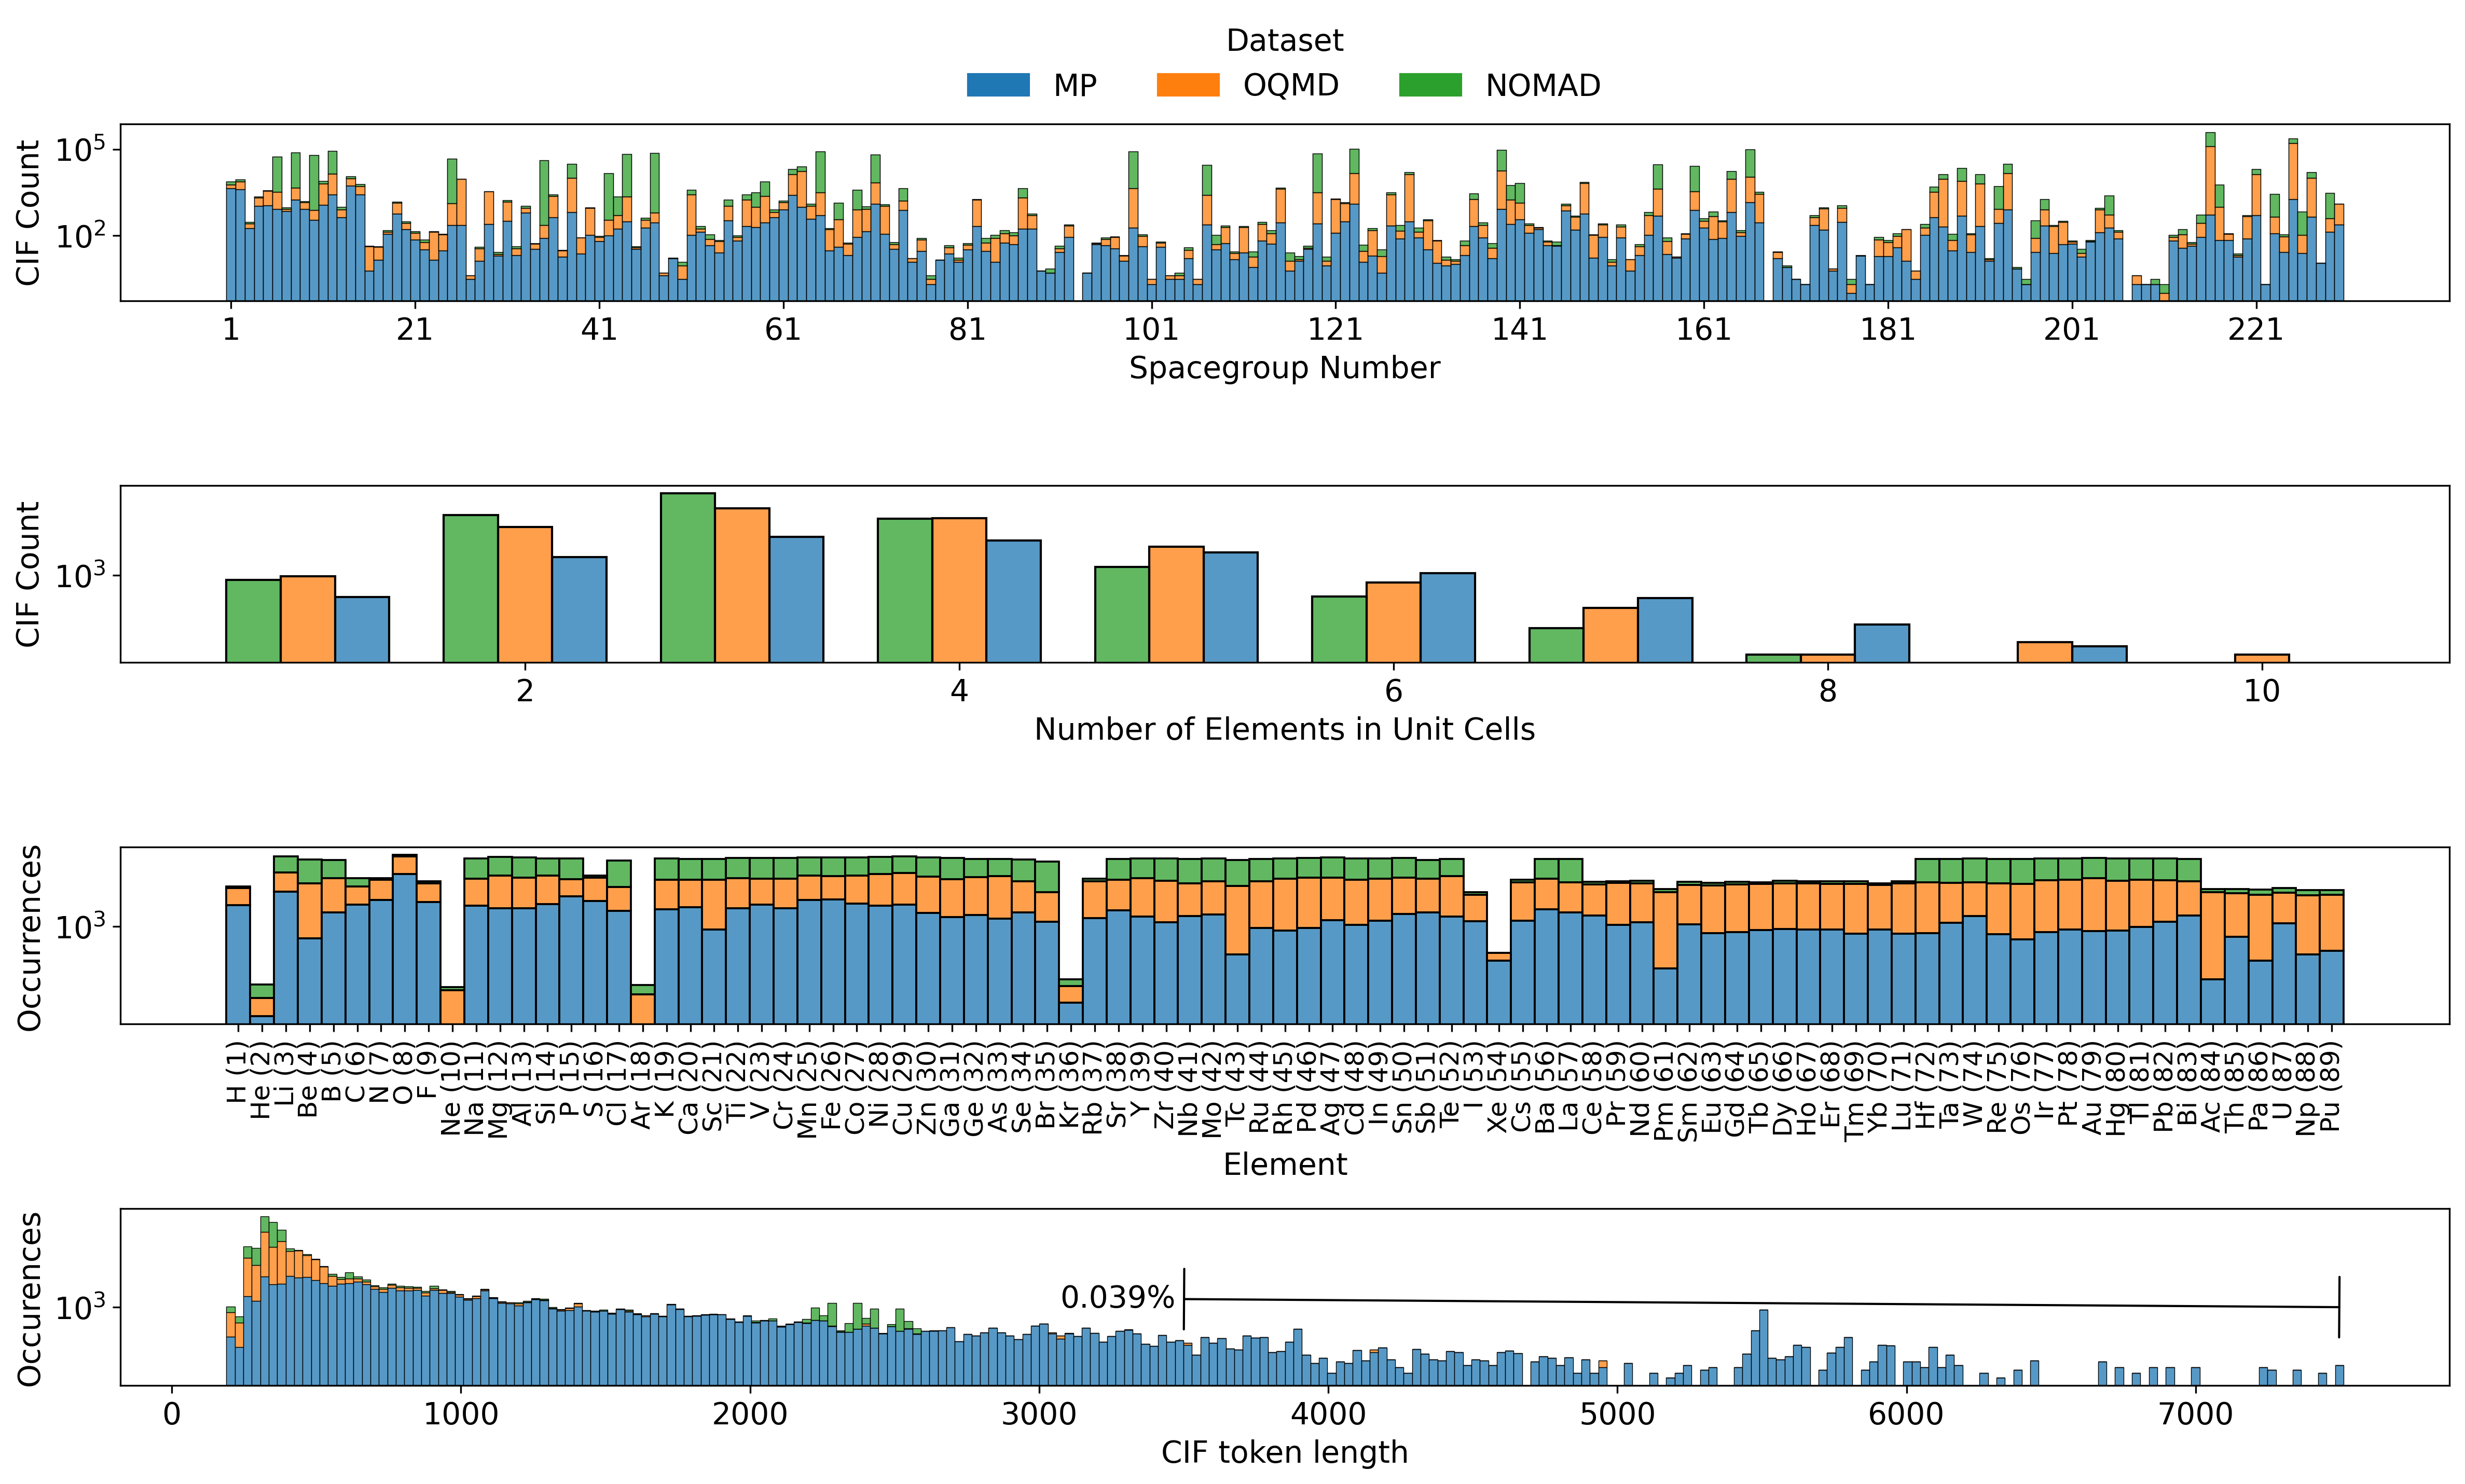

In [77]:
font_config = {
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "legend.title_fontsize": 14,
}
plt.rcParams.update(font_config)

# Visualize and save output
visualize_data(
    data_df,
    exploded_df,
    species_order, 
    species_order_labels,
    "dataset_statistics_NOMA",
    figsize=(16,10),
    bbox_to_anchor=(0.5, 1.7),
    log_scale = True,
    legend_labels = ['MP', 'OQMD', 'NOMAD'],
    cif_token_len_bins = 250,
    special_element_fontsize = 12,
)

In [78]:
# Configuration
DATA_PATHS_CHILI = [
    '../data/chili100k_clean/serialized/test.h5',
]
DEBUG_MAX_CHILI = None

data_df_chili = process_all_files(DATA_PATHS_CHILI, DEBUG_MAX_CHILI)

# Explode atomic data
exploded_df_chili = data_df_chili.explode(['species', 'atomic_numbers'], ignore_index=True)
exploded_df_chili['atomic_numbers'] = exploded_df_chili['atomic_numbers'].astype(int)
exploded_df_chili['species'] = exploded_df_chili['species'].astype(str)
# Order species
species_order_chili = (
    exploded_df_chili[['species', 'atomic_numbers']]
    .drop_duplicates()
    .sort_values('atomic_numbers')['species']
    .unique()  # Ensure unique values
)
# Convert species to a categorical type with the desired order
exploded_df_chili['species'] = pd.Categorical(exploded_df_chili['species'], categories=species_order_chili, ordered=True)
# Define labels (use your predefined arrays if necessary)
species_order_labels_chili = [f"{species} ({atomic_number})" for species, atomic_number in zip(species_order_chili, sorted(exploded_df_chili['atomic_numbers'].unique()))]

Processing ../data/chili100k_clean/serialized/test.h5:   0%|          | 0/8201 [00:00<?, ?it/s]

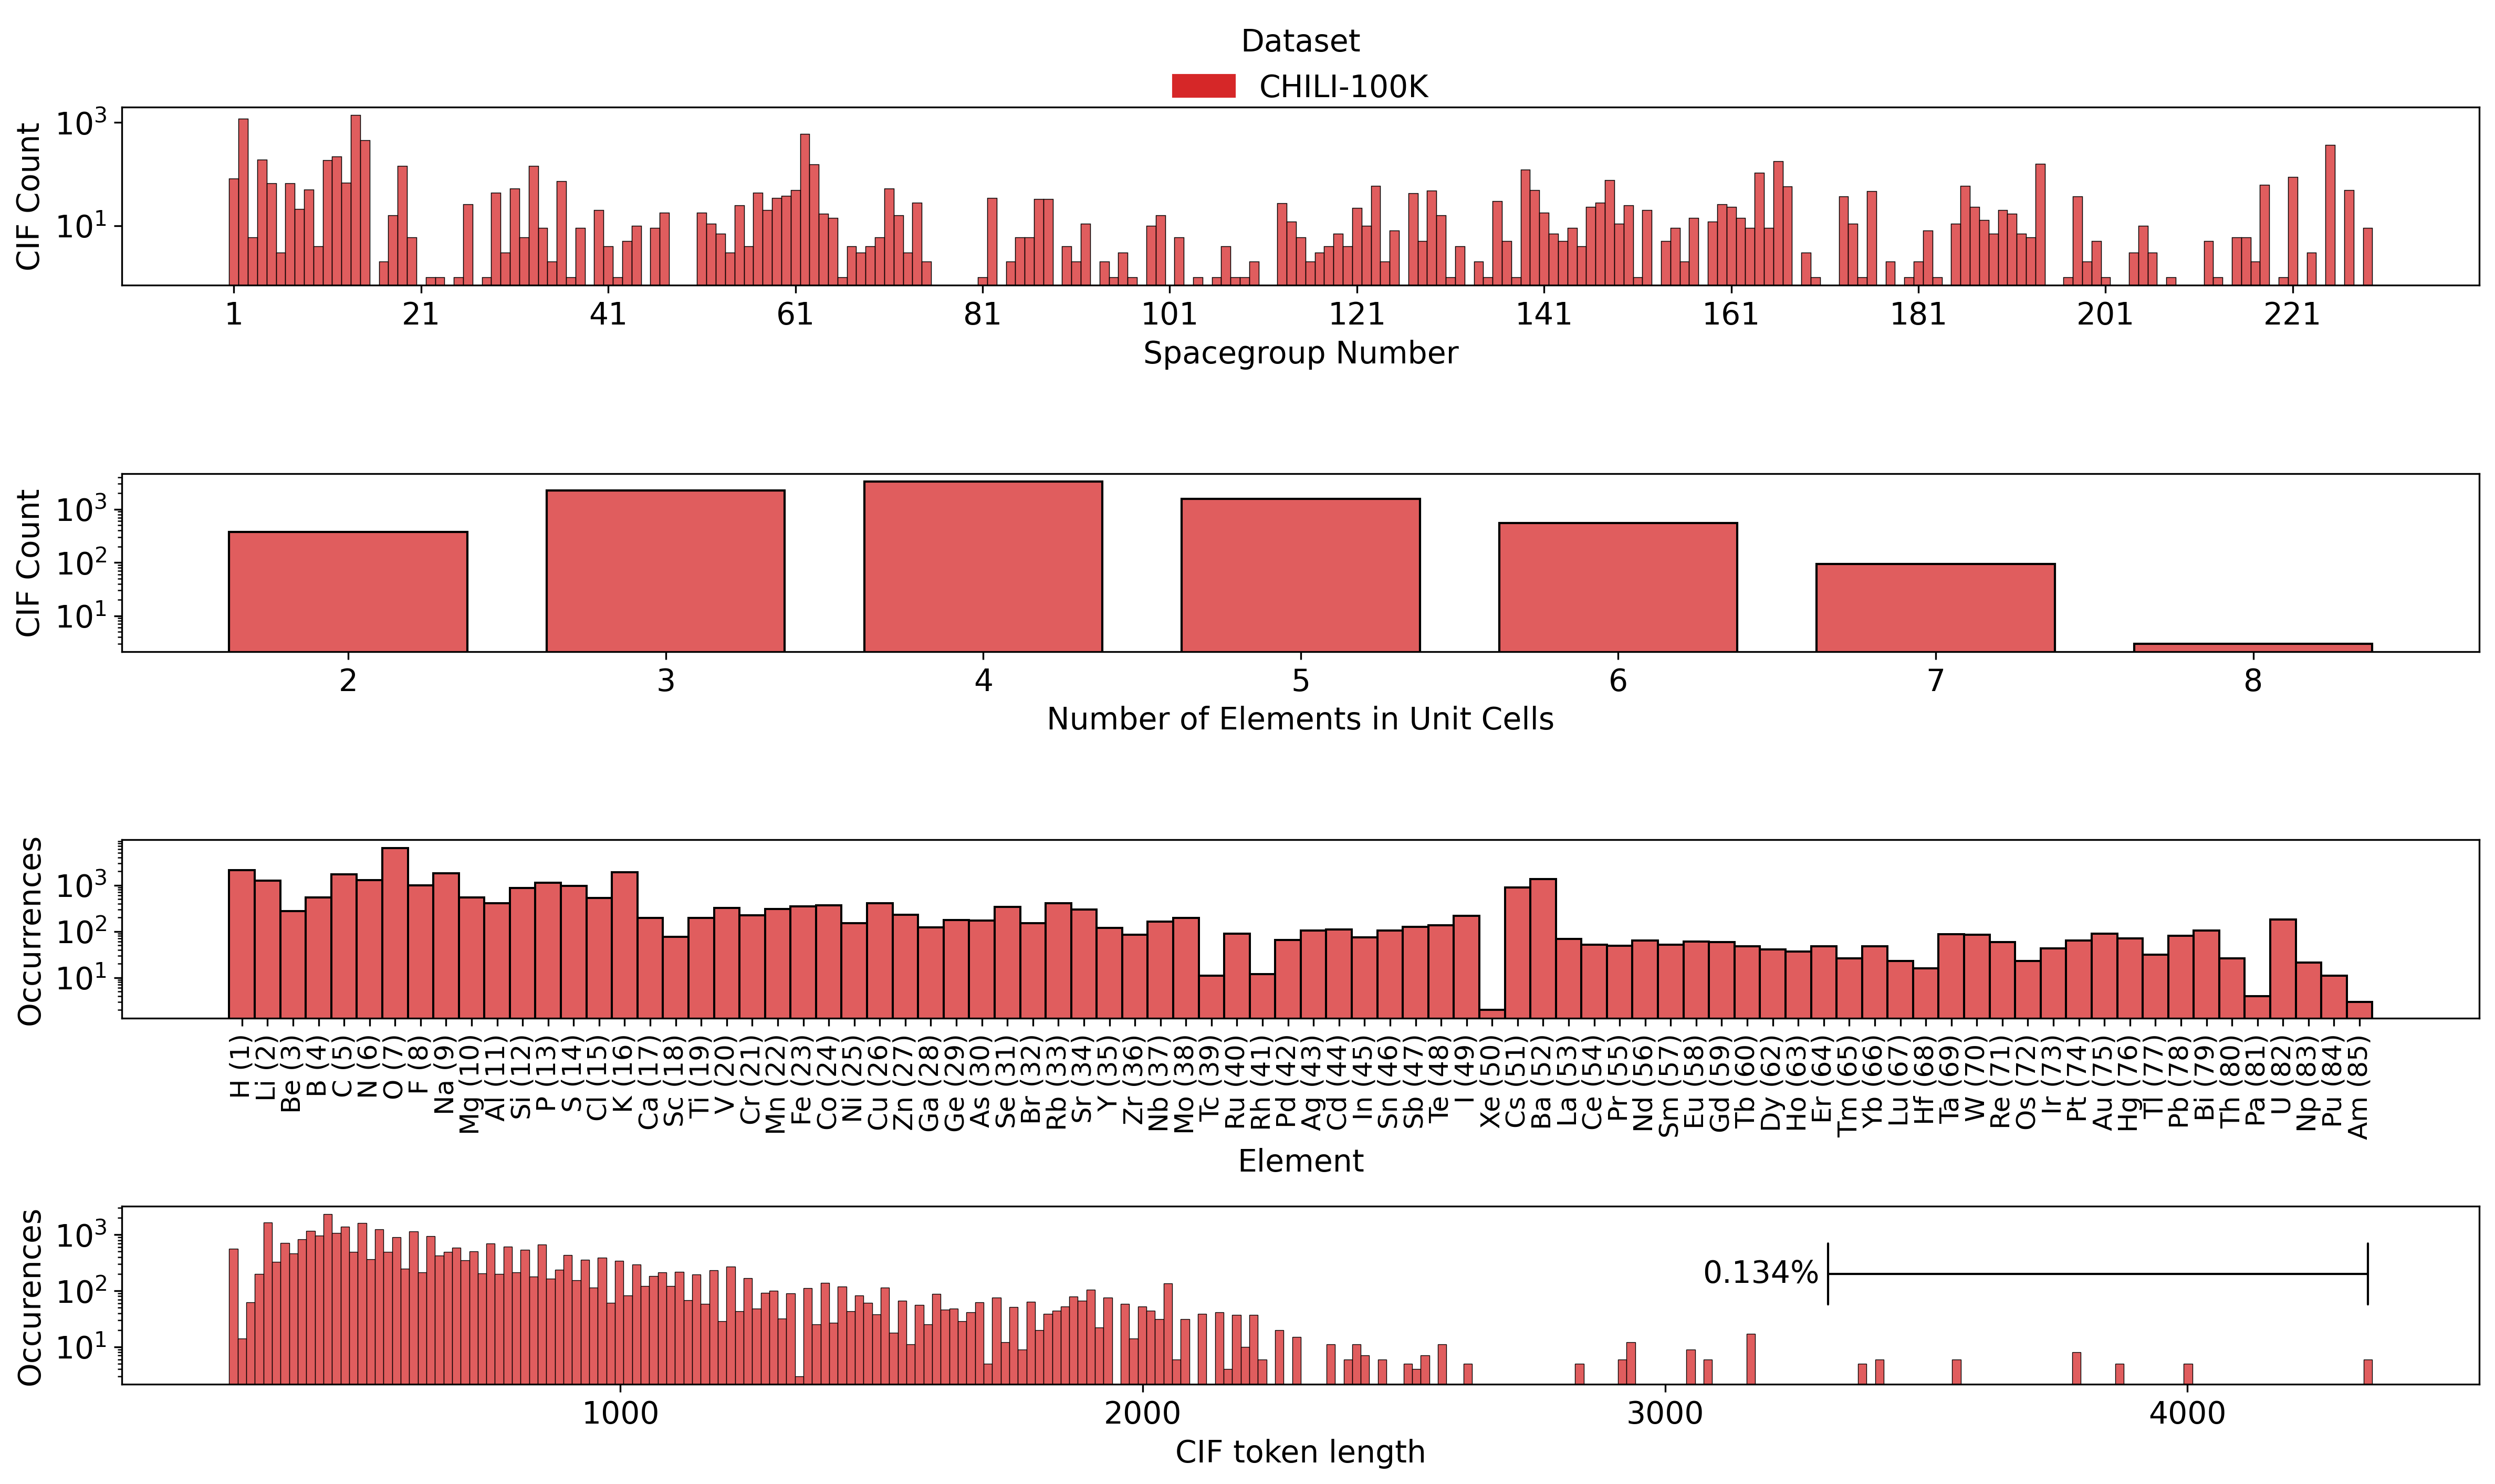

In [83]:
font_config = {
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "legend.title_fontsize": 14,
}
plt.rcParams.update(font_config)

# Visualize and save output
visualize_data(
    data_df_chili,
    exploded_df_chili,
    species_order_chili, 
    species_order_labels_chili,
    "dataset_statistics_CHILI",
    figsize=(16,10),
    bbox_to_anchor=(0.5, 1.6),
    log_scale = True,
    legend_labels = ['CHILI-100K'],
    legend_skip_colors = 3,
    cif_token_len_bins = 250,
    special_element_fontsize = 12,
    text_height = 200,
)

In [60]:
# Configuration
DATA_PATHS = [
    '../data/crystallm/full/serialized/train.h5',
    '../data/crystallm/full/serialized/val.h5',
    '../data/crystallm/full/serialized/test.h5',
    '../data/chili100k/full/serialized/train.h5',
    '../data/chili100k/full/serialized/val.h5',
    '../data/chili100k/full/serialized/test.h5',
]
DEBUG_MAX = None

data_df = process_all_files(DATA_PATHS, DEBUG_MAX)

# Explode atomic data
exploded_df = data_df.explode(['species', 'atomic_numbers'], ignore_index=True)
exploded_df['atomic_numbers'] = exploded_df['atomic_numbers'].astype(int)
exploded_df['species'] = exploded_df['species'].astype(str)
# Order species
species_order = (
    exploded_df[['species', 'atomic_numbers']]
    .drop_duplicates()
    .sort_values('atomic_numbers')['species']
    .unique()  # Ensure unique values
)
# Convert species to a categorical type with the desired order
exploded_df['species'] = pd.Categorical(exploded_df['species'], categories=species_order, ordered=True)
# Define labels (use your predefined arrays if necessary)
species_order_labels = [f"{species} ({atomic_number})" for species, atomic_number in zip(species_order, exploded_df['atomic_numbers'].unique())]

Processing ../data/crystallm/full/serialized/train.h5:   0%|          | 0/2169177 [00:00<?, ?it/s]

Processing ../data/crystallm/full/serialized/val.h5:   0%|          | 0/57084 [00:00<?, ?it/s]

Processing ../data/crystallm/full/serialized/test.h5:   0%|          | 0/57085 [00:00<?, ?it/s]

Processing ../data/chili100k/full/serialized/train.h5:   0%|          | 0/43107 [00:00<?, ?it/s]

Processing ../data/chili100k/full/serialized/val.h5:   0%|          | 0/1136 [00:00<?, ?it/s]

Processing ../data/chili100k/full/serialized/test.h5:   0%|          | 0/1136 [00:00<?, ?it/s]

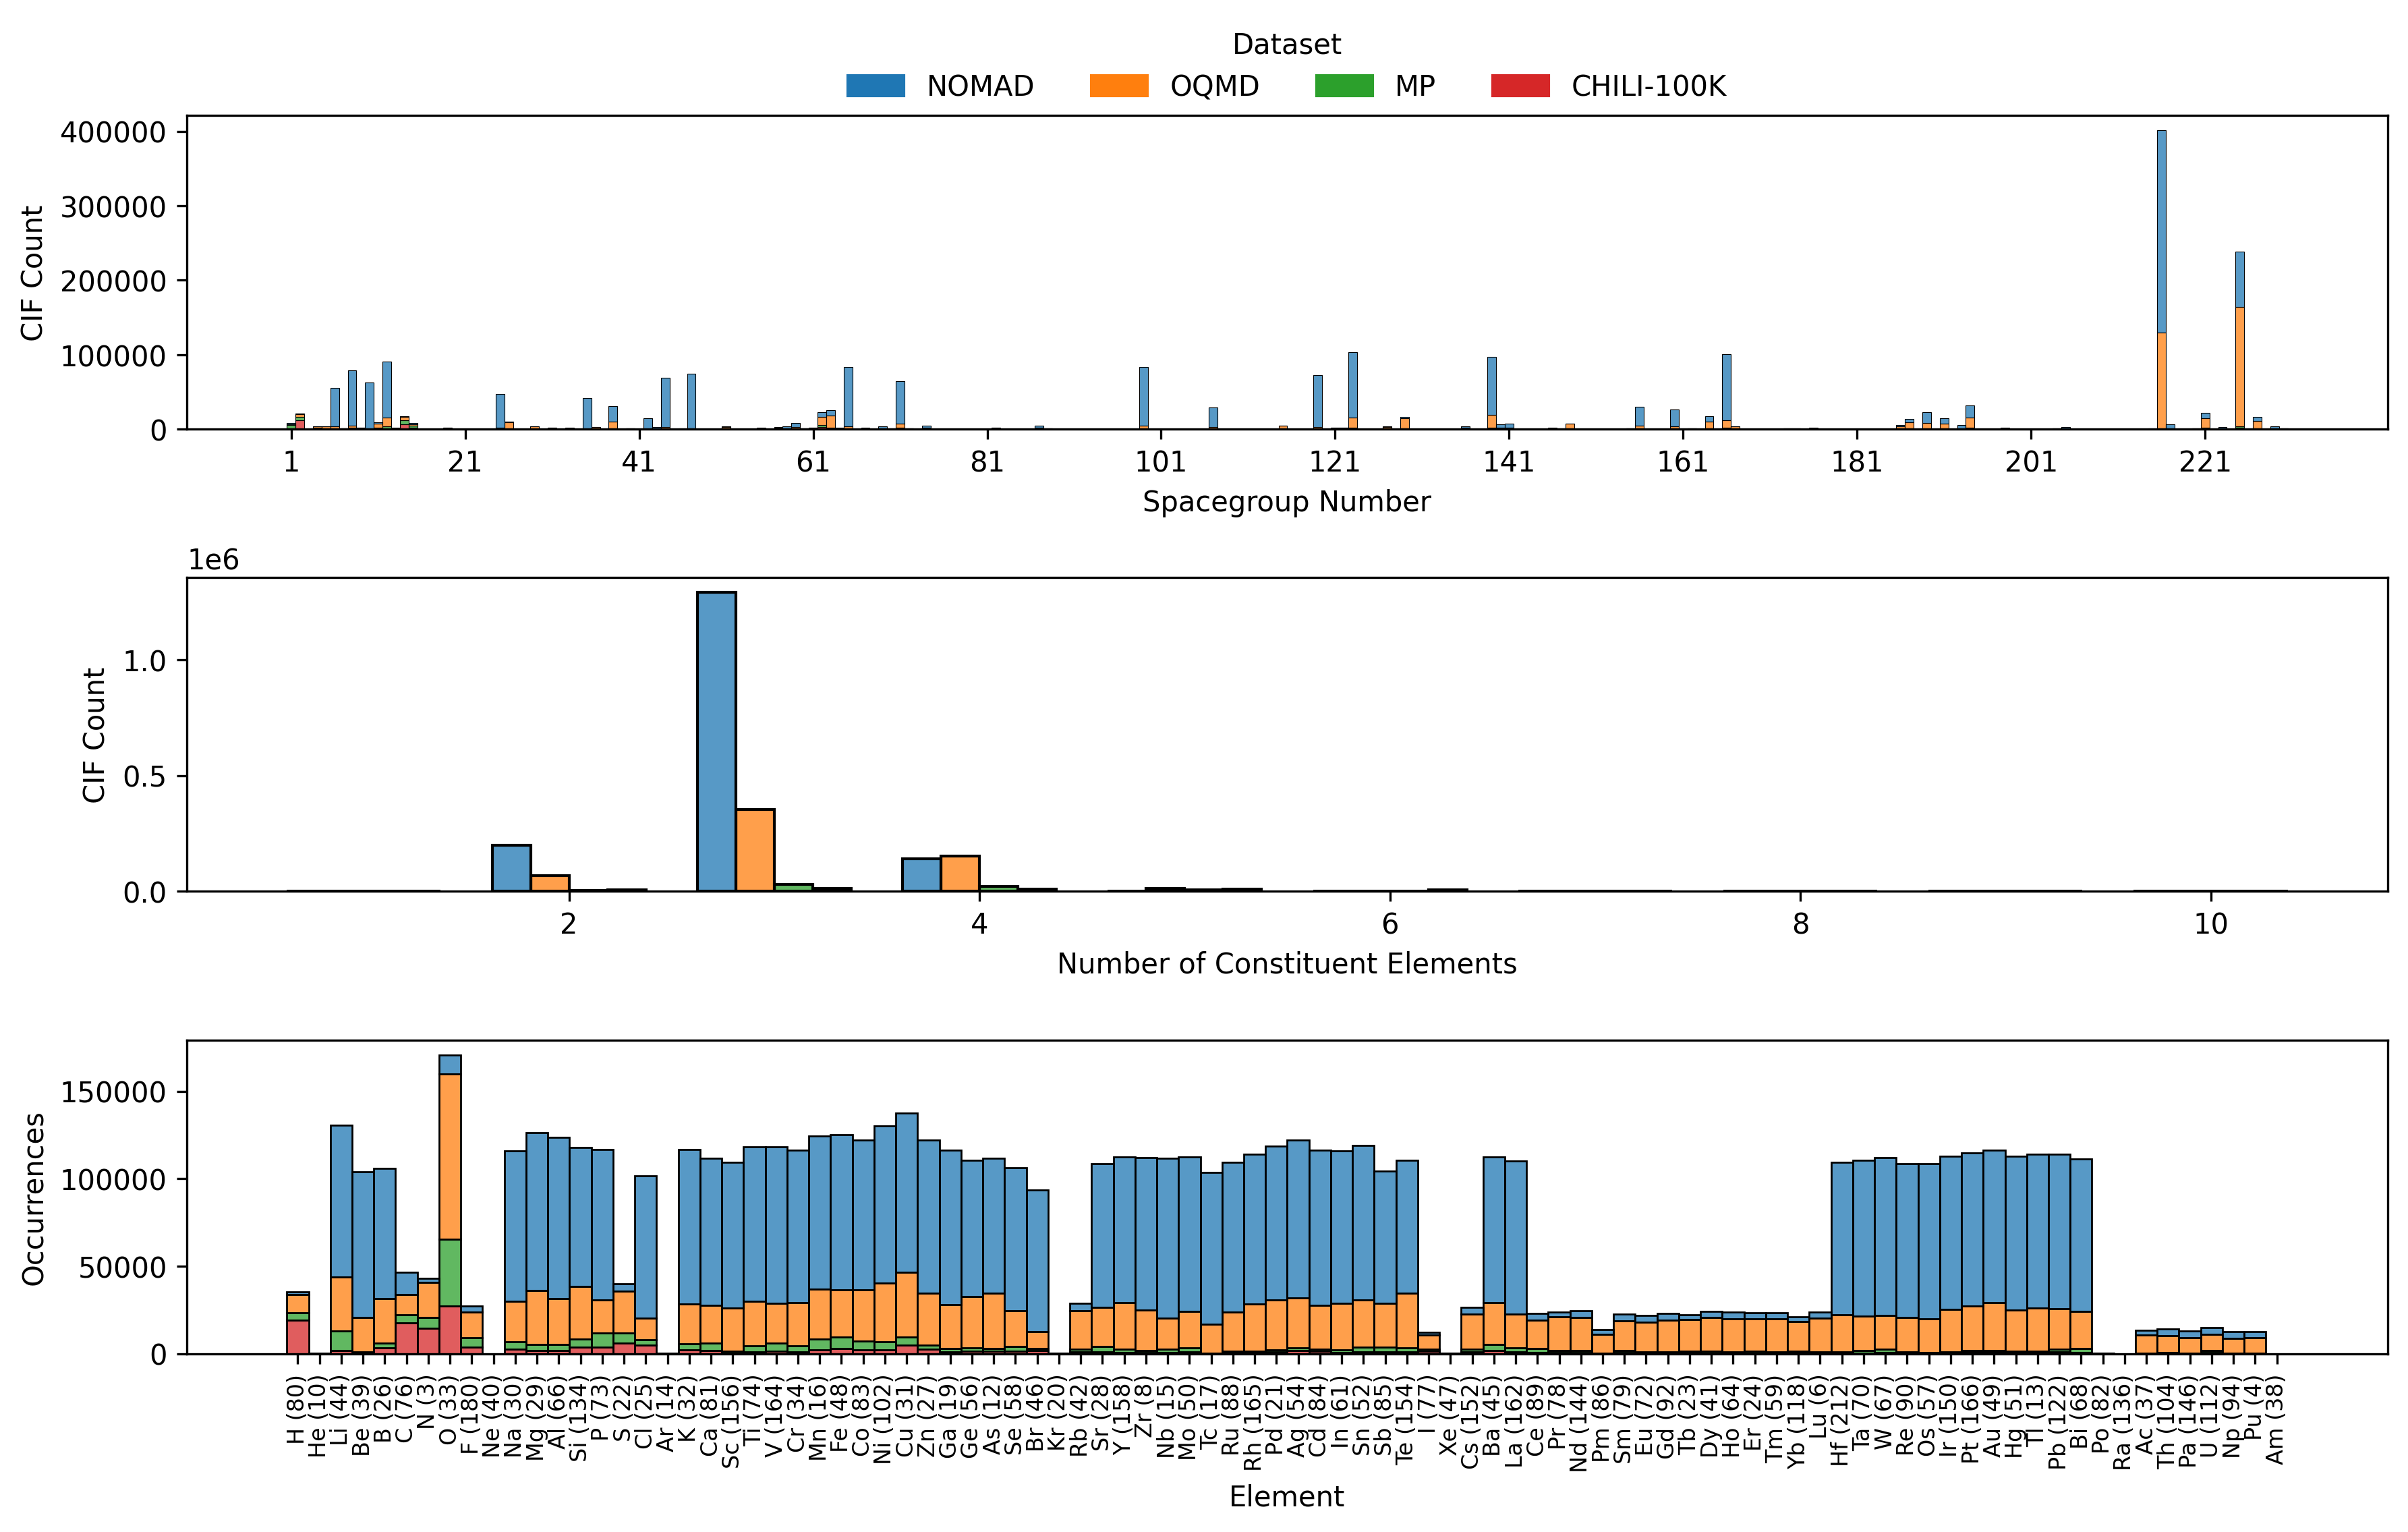

In [61]:
# Visualize and save output
visualize_data(
    data_df,
    exploded_df,
    species_order, 
    species_order_labels,
    "dataset_statistics_ALL",
    figsize=(12,8),
    bbox_to_anchor=(0.5, 1.35),
    log_scale = False,
)

## Other data figures for paper

Processing ../data/crystallm/full/serialized/train.h5:   0%|          | 0/20 [00:00<?, ?it/s]

<BarContainer object of 470 artists>

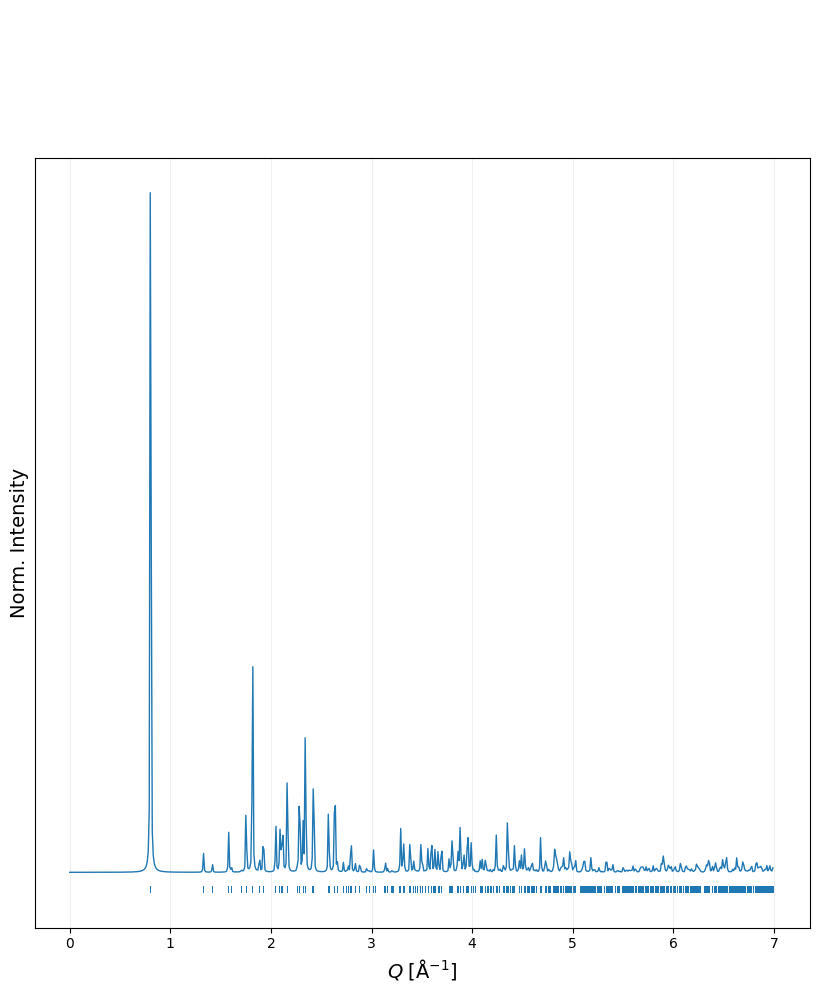

In [4]:
from pymatgen.core import Composition, Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import torch
import matplotlib.pyplot as plt

font_config = {
     "font.size": 12,
     "axes.titlesize": 14,
     "axes.labelsize": 14,
     "xtick.labelsize": 10,
     "ytick.labelsize": 14,
     "legend.fontsize": 12,
}
plt.rcParams.update(font_config)


# Configuration
DATA_PATHS = [
    '../data/crystallm/full/serialized/train.h5',
]
DEBUG_MAX = 20
i = 6
data_df = process_all_files(DATA_PATHS, DEBUG_MAX)
cif_string = data_df['cif_string'][i]

pxrd = generate_continuous_xrd_from_cif(
    cif_string,
    mask_prob=0.0,
    intensity_scale_range=None,
    noise_range=None,
    fwhm_range=[0.01, 0.01],
    qmax=7,
)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(
    pxrd['q'],
    pxrd['iq'],
    lw=1,
)

# Axis styling
ax.set(xlabel='$Q\;[\\mathrm{\\AA}^{-1}]$', ylabel='Norm. Intensity')
ax.grid(alpha=0.2)
ax.set_yticks([])
ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)

structure = Structure.from_str(cif_string, fmt="cif")
# print(structure)

# Initialize the XRD calculator using the specified wavelength
xrd_calculator = XRDCalculator(wavelength='CuKa')

qmax = 7.0
qmin = 0.0
# Calculate the XRD pattern from the structure
if qmax >= (((4 * np.pi) / xrd_calculator.wavelength) * np.sin(np.radians(180))):
    two_theta_range = None
else:
    tth_min = 2 * np.arcsin((qmin * xrd_calculator.wavelength) / (4 * np.pi))
    tth_max = 2 * np.arcsin((qmax * xrd_calculator.wavelength) / (4 * np.pi))
    two_theta_range = (tth_min, tth_max)

xrd_pattern = xrd_calculator.get_pattern(structure, two_theta_range=two_theta_range)

theta_radians = torch.tensor(np.radians(xrd_pattern.x / 2), dtype=torch.float32)
q_disc = 4 * np.pi * torch.sin(theta_radians) / xrd_calculator.wavelength
iq_disc = torch.tensor(xrd_pattern.y, dtype=torch.float32)

ax.bar(
    q_disc[q_disc < qmax],
    height=-np.ones_like(iq_disc[q_disc < qmax]) * 0.01,
    width=0.01,
    bottom=-0.02
)

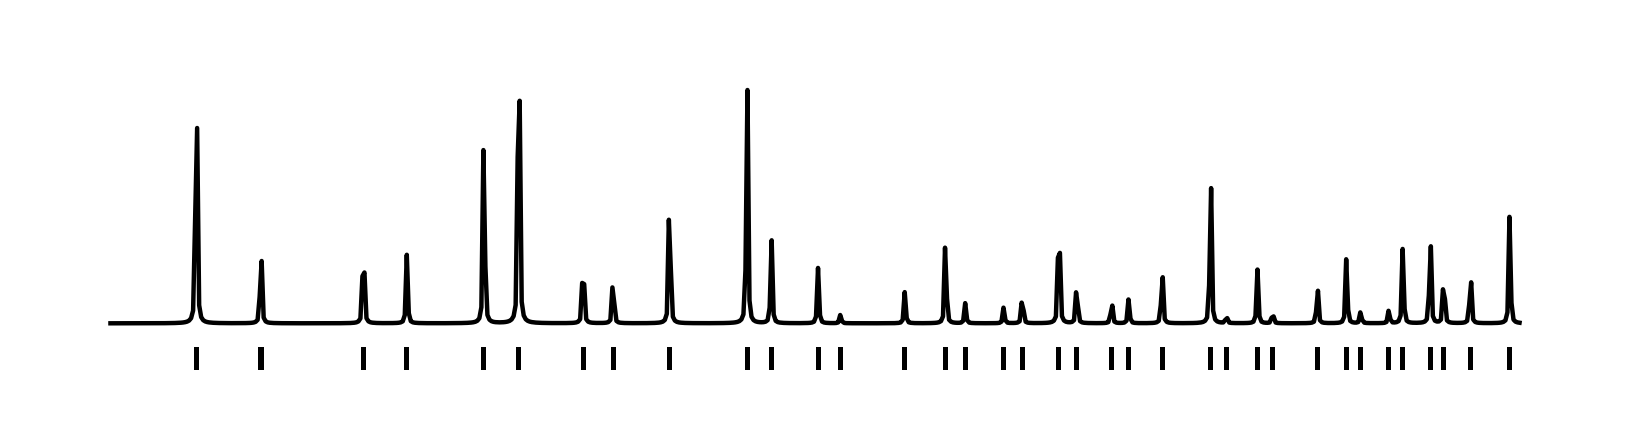

In [5]:
from pymatgen.core import Composition, Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import torch

font_config = {
     "font.size": 12,
     "axes.titlesize": 14,
     "axes.labelsize": 14,
     "xtick.labelsize": 10,
     "ytick.labelsize": 14,
     "legend.fontsize": 12,
}
plt.rcParams.update(font_config)

cif_string = """
data_CdCl2
loop_
 _atom_type_symbol
 _atom_type_electronegativity
 _atom_type_radius
 _atom_type_ionic_radius
  Cd  1.7000  1.6200  0.9500
  Cl  3.0000  1.7500  1.8100
_symmetry_space_group_name_H-M R-3m
_cell_length_a   6.2300
_cell_length_b   6.2300
_cell_length_c   6.2300
_cell_angle_alpha   90.0000
_cell_angle_beta    90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   166
loop_
 _atom_site_label
 _atom_site_type_symbol
 _atom_site_symmetry_multiplicity
 _atom_site_Wyckoff_symbol
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
  Cd1 Cd 1 a 0.0000 0.0000 0.0000 1.0000
  Cl1 Cl 2 c 0.2500 0.2500 0.2500 1.0000
"""

pxrd = generate_continuous_xrd_from_cif(
    cif_string,
    mask_prob=0.0,
    intensity_scale_range=None,
    noise_range=None,
    fwhm_range=[0.01, 0.01],
    qmax=8.0,
    qmin=1.0
)
fig, ax = plt.subplots(figsize=(5,1), dpi=400)
ax.plot(
    pxrd['q'],
    pxrd['iq'],
    color='k',
    lw=0.8,
)

# Axis styling
ax.set(xlabel='$Q\;[\\mathrm{\\AA}^{-1}]$', ylabel='Norm. Intensity')
ax.grid(alpha=0.2)
ax.set_yticks([])
ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)

structure = Structure.from_str(cif_string, fmt="cif")
# print(structure)

# Initialize the XRD calculator using the specified wavelength
xrd_calculator = XRDCalculator(wavelength='CuKa')

qmax = 8.0
qmin = 1.0
# Calculate the XRD pattern from the structure
if qmax >= (((4 * np.pi) / xrd_calculator.wavelength) * np.sin(np.radians(180))):
    two_theta_range = None
else:
    tth_min = 2 * np.arcsin((qmin * xrd_calculator.wavelength) / (4 * np.pi))
    tth_max = 2 * np.arcsin((qmax * xrd_calculator.wavelength) / (4 * np.pi))
    two_theta_range = (tth_min, tth_max)

xrd_pattern = xrd_calculator.get_pattern(structure, two_theta_range=two_theta_range)

theta_radians = torch.tensor(np.radians(xrd_pattern.x / 2), dtype=torch.float32)
q_disc = 4 * np.pi * torch.sin(theta_radians) / xrd_calculator.wavelength
iq_disc = torch.tensor(xrd_pattern.y, dtype=torch.float32)

ax.bar(
    q_disc[q_disc < qmax],
    height=-np.ones_like(iq_disc[q_disc < qmax]) * 0.1,
    width=0.025,
    bottom=-0.1,
    color='k'
)
plt.axis('off')
fig.savefig("CdCl.png", transparent=True)